# Transfer learning with Keras (version 2.2.0)
Using a VGG16 convolutional neural network previously trained for general image classification, we want to build a new model to specifically categorize three types of images: cheese, milk and yogurt.

## 1. Build a new image classification model based on VGG16 architecture using imagenet weights
See : https://keras.io/applications/#vgg16

In [7]:
#Force images to be plotted inline
%matplotlib inline

#Import required modules
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
#from __future__ import print_function    #Required for backwards compatibility.  print becomes a function in Python 3.x


In [8]:
# Import the VGG16 architecture and weights without the top output layer.
# This means that the last layer will be of shape 7x7x512.  
# We will be adding new layers on top of this to build our own model.
from keras.applications import VGG16
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Uncomment the line below to visualize the vgg_conv network architecture
#vgg_conv.summary()

To train the new model, we will use 180 images of cheese, milk and yougurt downloaded from the web.  Since these can be quite varied, it is important to ensure that the distribution of images is similar (i.e. cropped images showing a single item with as few other items in the image as possible).  Furthermore, we need to split the images between a training dataset and a validation dataset that will be used to fit the model.
For each dataset, the images are stored in three directories, one representing each class:
- datasets\train\cheese (60 images)
- datasets\train\milk (60 images)
- datasets\train\yougurt (60 images)
- datasets\validation\cheese (20 images)
- datasets\validation\milk (20 images)
- datasets\validation\yougurt (18 images)

### Image preprocessing
The images in our datasets are of various different dimensions.  Our VGG16 model is expecting 224x224 images with 3 channels (RGB).  Also, in order to improve training accuracy, we will be augmenting the number of images by applying random transformations to the images in the directories.  

In [9]:
# Variable pointing to image dataset directories
train_dir = './datasets/train'
validation_dir = './datasets/validation'


# Count number of base image files in training and validation directories
nTrainImages = sum([len(files) for r, d, files in os.walk(train_dir)])
nValImages = sum([len(files) for r, d, files in os.walk(validation_dir)])

# Number of times a randomly modified image will be generated from a base image
dataAugmentation = 5
                  
# Total number of examples that will be available for the model
nTrain = nTrainImages*dataAugmentation
nVal = nValImages*dataAugmentation

#Maximum number of images to generate at a time. Adjust for performance (i.e. images must fit in memory)
batch_size_max = 30  

#Determine batch generation sizes as largest multiplication factor smaller or equal to max batch size
for n in range(2,nTrainImages):
    if (nTrainImages%n==0) & (n<=min(nTrainImages,32)):
        train_gen_batch_size=n
        
for n in range(2,nValImages):
    if (nValImages%n==0) & (n<=min(nValImages,32)):
        val_gen_batch_size=n

print("Train new model on",str(nTrain),"examples using batch size of",train_gen_batch_size,"to augment data")
print("Validate model on",str(nVal),"examples using batch size of",val_gen_batch_size,"to augment data")

Train new model on 900 examples using batch size of 30 to augment data
Validate model on 255 examples using batch size of 17 to augment data


### Calculate last layer of imported VGG16 network
We need to calculate the values of the activations at the last layer of the VGG16 model which is of shape (7 x 7 x 512).
To do this, we will calculate and store the predictions for our training data using the model as it is currently loaded (i.e. without the top, final layer).  These predictions will be stored in the train_features vector of size (nTrain x 7 x 7 x 512).
This vector will serve as input to the new layers we will add to the model later.


In [10]:
#Setup the image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

batch_size = train_gen_batch_size

#Initialize the features and labels arrays to zero
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

temp_dir=None
# Uncomment the line below if you want to save the generated images to disk (allows you to see if transformations make sense)
#temp_dir = './temp'

# Generate the last layer activations for the training set
i = 0
for inputs_batch, labels_batch in datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    save_to_dir=temp_dir):
    print("Batch",i+1,"out of",nTrain/batch_size,"[",i*batch_size,":",(i+1)*batch_size,"]")
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size:(i+1)*batch_size] = features_batch
    train_labels[i * batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if (i+1) * batch_size >= nTrain:
        break

#This last layer must now be reshaped as a feature input matrix for the new layers we will be adding
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))
print("Done!")

Found 180 images belonging to 3 classes.
Batch 0 out of 30.0 [ 0 : 30 ]
Batch 1 out of 30.0 [ 30 : 60 ]
Batch 2 out of 30.0 [ 60 : 90 ]
Batch 3 out of 30.0 [ 90 : 120 ]
Batch 4 out of 30.0 [ 120 : 150 ]
Batch 5 out of 30.0 [ 150 : 180 ]
Batch 6 out of 30.0 [ 180 : 210 ]
Batch 7 out of 30.0 [ 210 : 240 ]
Batch 8 out of 30.0 [ 240 : 270 ]
Batch 9 out of 30.0 [ 270 : 300 ]
Batch 10 out of 30.0 [ 300 : 330 ]
Batch 11 out of 30.0 [ 330 : 360 ]
Batch 12 out of 30.0 [ 360 : 390 ]
Batch 13 out of 30.0 [ 390 : 420 ]
Batch 14 out of 30.0 [ 420 : 450 ]
Batch 15 out of 30.0 [ 450 : 480 ]
Batch 16 out of 30.0 [ 480 : 510 ]
Batch 17 out of 30.0 [ 510 : 540 ]
Batch 18 out of 30.0 [ 540 : 570 ]
Batch 19 out of 30.0 [ 570 : 600 ]
Batch 20 out of 30.0 [ 600 : 630 ]
Batch 21 out of 30.0 [ 630 : 660 ]
Batch 22 out of 30.0 [ 660 : 690 ]
Batch 23 out of 30.0 [ 690 : 720 ]
Batch 24 out of 30.0 [ 720 : 750 ]
Batch 25 out of 30.0 [ 750 : 780 ]
Batch 26 out of 30.0 [ 780 : 810 ]
Batch 27 out of 30.0 [ 810 : 840

In [11]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

batch_size = val_gen_batch_size

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Use seed=1 to maintain validation set composition between tests
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=1)

i = 0
for inputs_batch, labels_batch in validation_generator:
    print("Batch",i+1,"out of",nVal/batch_size,"[",i*batch_size,":",(i+1)*batch_size,"]")
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size:(i+1)*batch_size] = features_batch
    validation_labels[i * batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if (i+1) * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 51 images belonging to 3 classes.
Batch 1 out of 15.0 [ 0 : 17 ]
Batch 2 out of 15.0 [ 17 : 34 ]
Batch 3 out of 15.0 [ 34 : 51 ]
Batch 4 out of 15.0 [ 51 : 68 ]
Batch 5 out of 15.0 [ 68 : 85 ]
Batch 6 out of 15.0 [ 85 : 102 ]
Batch 7 out of 15.0 [ 102 : 119 ]
Batch 8 out of 15.0 [ 119 : 136 ]
Batch 9 out of 15.0 [ 136 : 153 ]
Batch 10 out of 15.0 [ 153 : 170 ]
Batch 11 out of 15.0 [ 170 : 187 ]
Batch 12 out of 15.0 [ 187 : 204 ]
Batch 13 out of 15.0 [ 204 : 221 ]
Batch 14 out of 15.0 [ 221 : 238 ]


### Create your own model and train the network
To create our own model, we will be adding some layers on top of the imported VGG16 network.

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 900 samples, validate on 255 samples
Epoch 1/20
900/900 [==============================] - 16s 18ms/step - loss: 1.5559 - acc: 0.5722 - val_loss: 1.0349 - val_acc: 0.5333
Epoch 2/20
900/900 [==============================] - 16s 17ms/step - loss: 0.5251 - acc: 0.7667 - val_loss: 0.6696 - val_acc: 0.6588
Epoch 3/20
900/900 [==============================] - 17s 19ms/step - loss: 0.4362 - acc: 0.8100 - val_loss: 0.7542 - val_acc: 0.6627
Epoch 4/20
900/900 [==============================] - 17s 18ms/step - loss: 0.2462 - acc: 0.8733 - val_loss: 0.4778 - val_acc: 0.7412
Epoch 5/20
900/900 [==============================] - 16s 18ms/step - loss: 0.2262 - acc: 0.8933 - val_loss: 0.6566 - val_acc: 0.7922
Epoch 6/20
900/900 [==============================] - 16s 18ms/step - loss: 0.1509 - acc: 0.9267 - val_loss: 0.3541 - val_acc: 0.8157
Epoch 7/20
900/900 [==============================] - 16s 18ms/step - loss: 0.1048 - acc: 0.9456 - val_loss: 0.6827 - val_acc: 0.8000
Epoch 8/20
900/9

In [13]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [14]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [15]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 1/255


C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


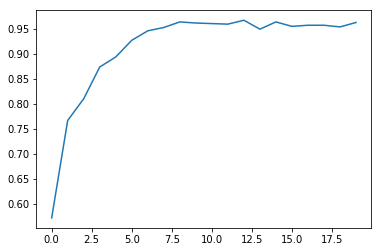

In [16]:
from matplotlib import pyplot
# plot metrics
pyplot.plot(history.history['acc'])
pyplot.show()

### Let us see which images were predicted wrongly

Original label:cheese\Cheese647.jpg, Prediction :cheese, confidence : 1.000


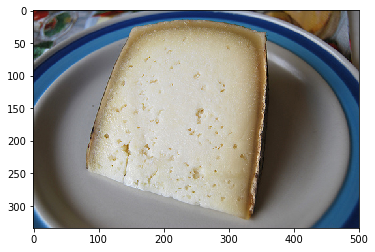

In [17]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

# Use the code below to save the model and weights to disk

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Use the code below to open and compile the saved model and weights

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
score = loaded_model.evaluate(validation_features, validation_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Use the code below to test model on new images

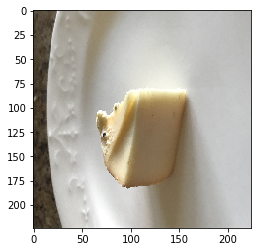

20180729_135708789_iOS.jpg is cheese 99.9919056892395 % sure.


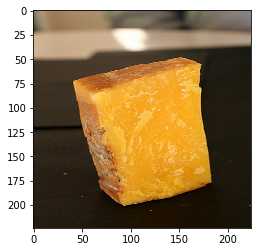

Cheese527.jpg is cheese 100.0 % sure.


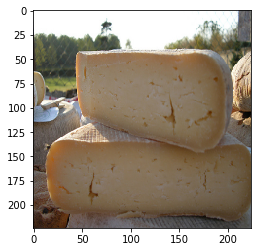

Cheese530.jpg is cheese 100.0 % sure.


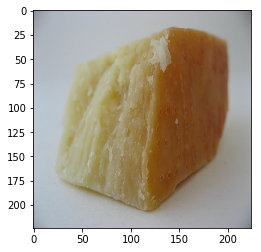

Cheese540.jpg is cheese 99.9997615814209 % sure.


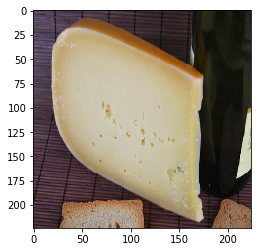

Cheese559.jpg is cheese 100.0 % sure.


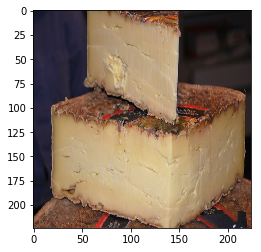

Cheese561.jpg is cheese 99.99997615814209 % sure.


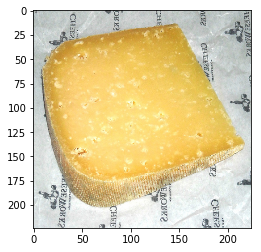

Cheese562.jpg is cheese 99.86342787742615 % sure.


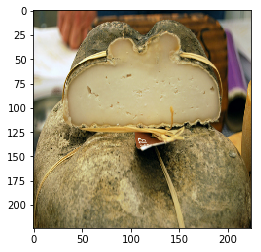

Cheese563.jpg is cheese 100.0 % sure.


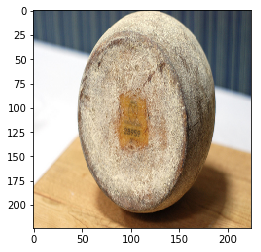

Cheese564.jpg is cheese 99.9972939491272 % sure.


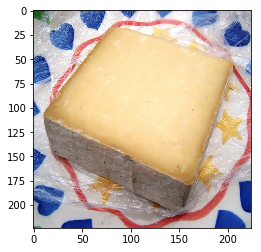

Cheese567.jpg is cheese 100.0 % sure.


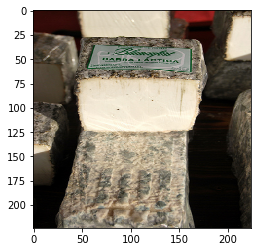

Cheese572.jpg is cheese 100.0 % sure.


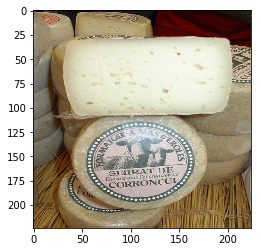

Cheese592.jpg is cheese 91.01675152778625 % sure.


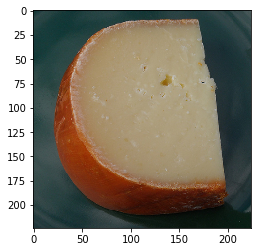

Cheese603.jpg is cheese 98.87969493865967 % sure.


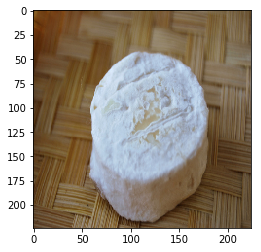

Cheese611.jpg is cheese 100.0 % sure.


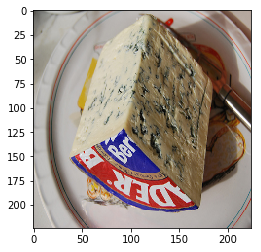

Cheese627.jpg is cheese 99.97212290763855 % sure.


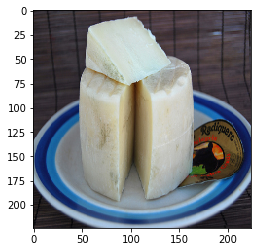

Cheese628.jpg is cheese 82.11357593536377 % sure.


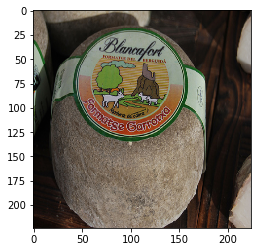

Cheese632.jpg is yogurt 99.08530116081238 % sure.


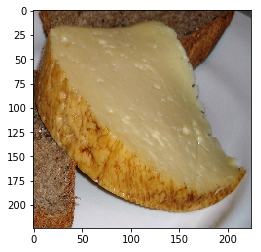

Cheese636.jpg is cheese 99.99865293502808 % sure.


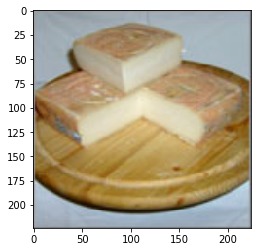

Cheese637.jpg is yogurt 99.71020817756653 % sure.


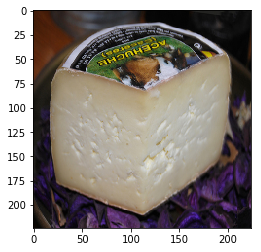

Cheese642.jpg is cheese 97.81630635261536 % sure.


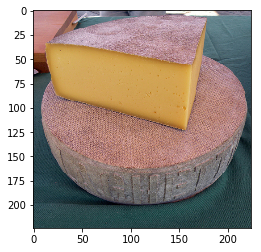

Cheese646.jpg is cheese 99.99725818634033 % sure.


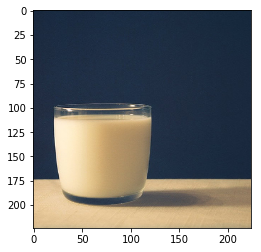

Milk1002.jpg is milk 99.99997615814209 % sure.


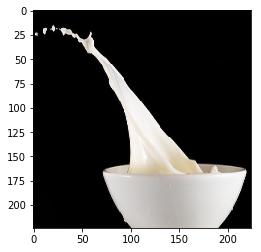

Milk1018.jpg is milk 99.82946515083313 % sure.


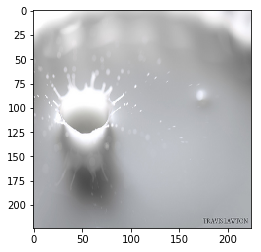

Milk1029.jpg is milk 99.99991655349731 % sure.


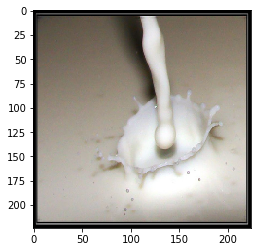

Milk1038.jpg is milk 99.99911785125732 % sure.


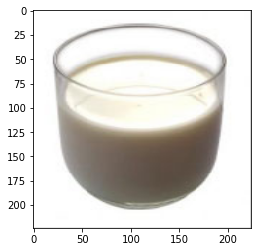

Milk1056.jpg is milk 99.99998807907104 % sure.


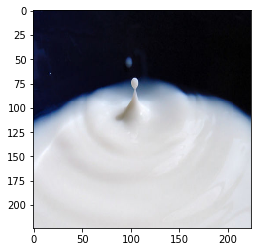

Milk1087.jpg is milk 99.80175495147705 % sure.


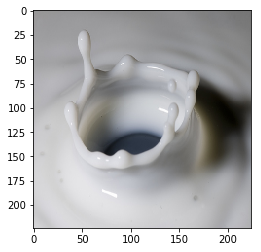

Milk1094.jpg is milk 55.37467002868652 % sure.


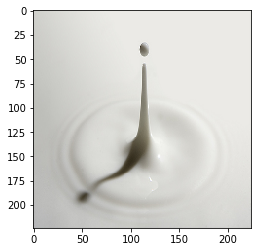

Milk1097.jpg is milk 100.0 % sure.


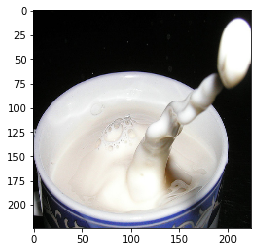

Milk1099.jpg is yogurt 65.79917669296265 % sure.


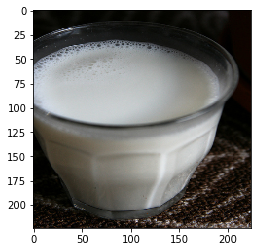

Milk1109.jpg is milk 97.53908514976501 % sure.


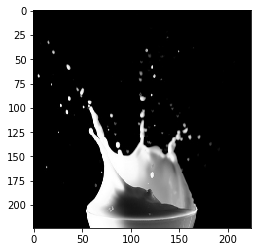

Milk858.jpg is milk 100.0 % sure.


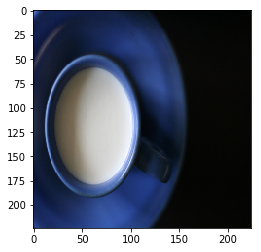

Milk864.jpg is yogurt 79.00468111038208 % sure.


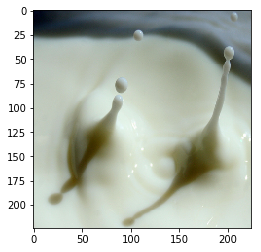

Milk869.jpg is milk 99.99918937683105 % sure.


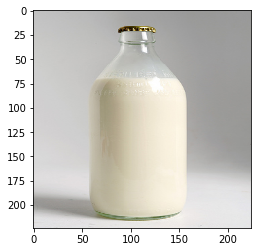

Milk874.jpg is milk 99.99966621398926 % sure.


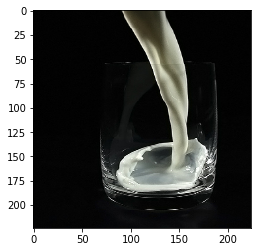

Milk900.jpg is milk 98.73170256614685 % sure.


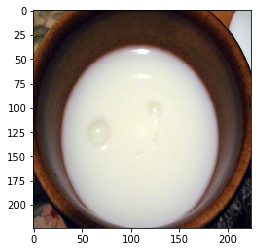

Milk911.jpg is yogurt 99.3276596069336 % sure.


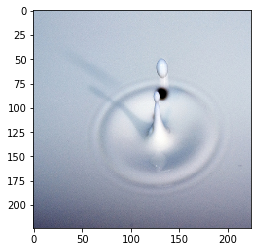

Milk952.jpg is milk 99.99998807907104 % sure.


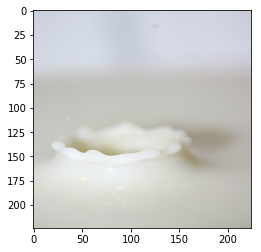

Milk984.jpg is milk 99.99852180480957 % sure.


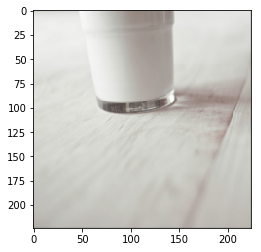

Milk986.jpg is milk 99.88137483596802 % sure.


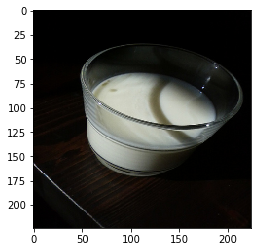

Milk996.jpg is milk 85.20559668540955 % sure.


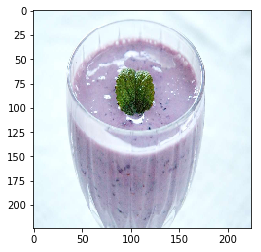

Yogurt1009.jpg is yogurt 99.9195396900177 % sure.


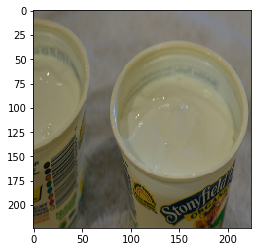

Yogurt1040.jpg is milk 93.52626204490662 % sure.


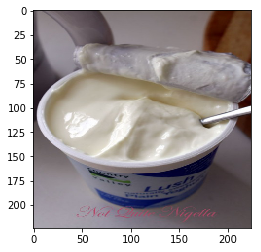

Yogurt1044.jpg is yogurt 100.0 % sure.


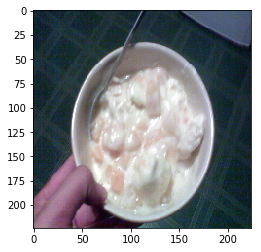

Yogurt1052.jpg is yogurt 99.99905824661255 % sure.


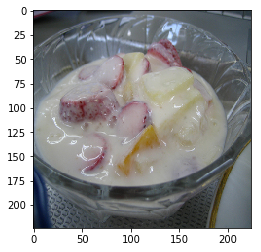

Yogurt1067.jpg is yogurt 100.0 % sure.


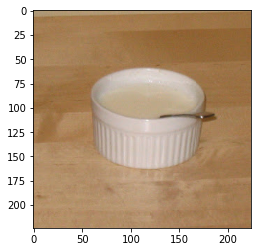

Yogurt1072.jpg is milk 99.99221563339233 % sure.


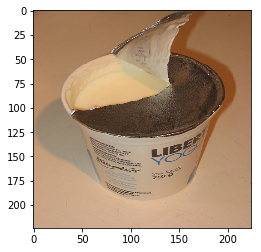

Yogurt1074.jpg is yogurt 99.93882179260254 % sure.


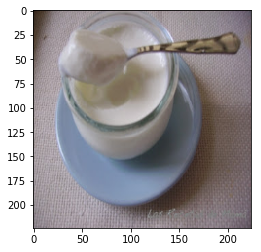

Yogurt843.jpg is yogurt 99.89237189292908 % sure.


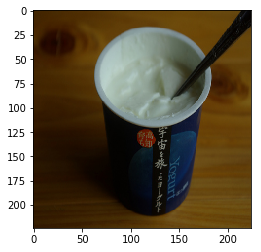

Yogurt873.jpg is yogurt 98.38128089904785 % sure.


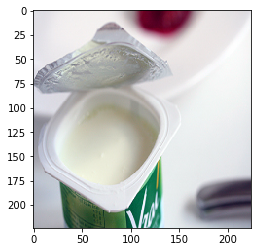

Yogurt875.jpg is yogurt 99.97323155403137 % sure.


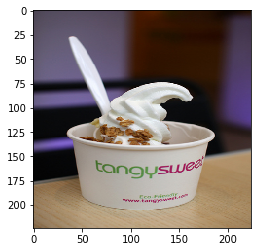

Yogurt955.jpg is yogurt 100.0 % sure.


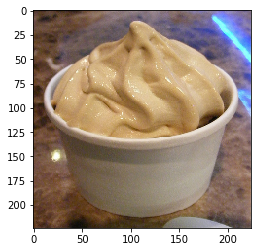

Yogurt971.jpg is yogurt 100.0 % sure.


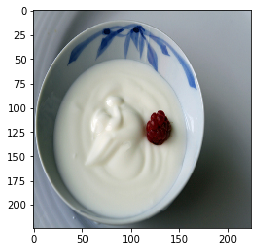

Yogurt982.jpg is yogurt 99.99998807907104 % sure.


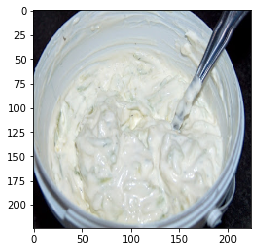

Yogurt988.jpg is yogurt 99.88064765930176 % sure.


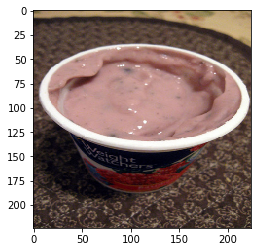

Yogurt989.jpg is yogurt 100.0 % sure.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from skimage.transform import resize

test_dir = './test'

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    image = np.array(plt.imread(addr))
    image = resize(image, (224,224),mode='constant')
    return image

#directory = os.fsencode(directory_in_str)

for file in os.listdir(test_dir):
    filename = os.fsdecode(file)
    img = load_image(test_dir+"\\"+filename)  # Loads the image and resizes it to 224 x 224 x 3
    x = img_to_array(img)  # convert image to numpy array
    x = x.reshape((1,) + x.shape)  # prediction function is expecting an array of m images.  (1, 224, 224, 3)

    test_example = vgg_conv.predict(x)   #Calculate activation at last layer of VGG16 network.  (1, 7, 7, 512)

    test_example=np.reshape(test_example, (1, 7 * 7 * 512))  #Reshape to input expected to first layer of our model (1, 25088)

    #Input test_example to our model.  Output is the softmax results vector
    prob = model.predict(test_example)

    pred_class = np.argmax(prob) #Predicted class is the one with the highest probability in softmax vector
    pred_label = idx2label[pred_class]  #Get the corresponding label
    plt.imshow(x[0])
    plt.show()
    print(filename,"is",pred_label,prob[0,pred_class]*100,"% sure.")